## Import library

In [2]:
import numpy as np
import pandas as pd

from tensorflow.keras.layers import LSTM, Dense,Dropout
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import os
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

## Read dataset

In [3]:
# Đọc dữ liệu
standing_df = pd.read_csv("./D6T data/Standing.txt")
eating_df = pd.read_csv("./D6T data/Eating.txt")
watching_df = pd.read_csv("./D6T data/Watching_TV.txt")
# clapp_df = pd.read_csv("Clapping.txt")
talking_df = pd.read_csv("./D6T data/Talking_phone.txt")

X = []
y = []
no_of_timesteps = 20

### data processing 

In [54]:
dataset = standing_df.iloc[:,1:].values
n_sample = len(dataset)
for i in range(no_of_timesteps, n_sample):
    X.append(dataset[i-no_of_timesteps:i,:])
    y.append(np.array([1., 0., 0.,0.]))

dataset = eating_df.iloc[:,1:].values
n_sample = len(dataset)
for i in range(no_of_timesteps, n_sample):
    X.append(dataset[i-no_of_timesteps:i,:])
    y.append(np.array([0., 1., 0.,0.]))

dataset = watching_df.iloc[:,1:].values
n_sample = len(dataset)
for i in range(no_of_timesteps, n_sample):
    X.append(dataset[i-no_of_timesteps:i,:])
    y.append(np.array([0., 0., 1.,0.]))

dataset = talking_df.iloc[:,1:].values
n_sample = len(dataset)
for i in range(no_of_timesteps, n_sample):
    X.append(dataset[i-no_of_timesteps:i,:])
    y.append(np.array([0., 0.,0.,1.]))


In [55]:
import random


X, y = np.array(X), np.array(y)
print(X.shape, y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5,random_state= 42)
print(X_train.shape)
print(y_train.shape)

(12636, 20, 64) (12636, 4)
(8845, 20, 64)
(8845, 4)


## Training model

0. LSTM

In [56]:
model  = Sequential()
model.add(LSTM(units = 32, input_shape = (X.shape[1], X.shape[2])))
model.add(Dense(units = 4, activation="softmax"))
model.compile(optimizer="adam", metrics = ['accuracy'], loss = "categorical_crossentropy")

history_lstm = model.fit(X_train, y_train, epochs=50, verbose = 1,batch_size=64,validation_data=(X_val, y_val))

Epoch 1/50
139/139 [==============================] - 7s 14ms/step - loss: 0.6419 - accuracy: 0.8066 - val_loss: 0.3269 - val_accuracy: 0.9393
Epoch 2/50
139/139 [==============================] - 1s 9ms/step - loss: 0.2320 - accuracy: 0.9578 - val_loss: 0.1566 - val_accuracy: 0.9752
Epoch 3/50
139/139 [==============================] - 1s 8ms/step - loss: 0.1117 - accuracy: 0.9864 - val_loss: 0.0977 - val_accuracy: 0.9842
Epoch 4/50
139/139 [==============================] - 1s 9ms/step - loss: 0.0683 - accuracy: 0.9940 - val_loss: 0.0459 - val_accuracy: 0.9979
Epoch 5/50
139/139 [==============================] - 1s 9ms/step - loss: 0.0461 - accuracy: 0.9957 - val_loss: 0.0290 - val_accuracy: 1.0000
Epoch 6/50
139/139 [==============================] - 1s 9ms/step - loss: 0.0246 - accuracy: 0.9994 - val_loss: 0.0214 - val_accuracy: 1.0000
Epoch 7/50
139/139 [==============================] - 1s 9ms/step - loss: 0.0170 - accuracy: 0.9998 - val_loss: 0.0153 - val_accuracy: 0.9995
Epoch

In [58]:
def plot_model_acc_and_loss(history):
    
    # Evaluate train and validation accuracies and losses
    
    train_accuracy = np.array(history.history['accuracy'])*99.03
    val_accuracy = np.array(history.history['val_accuracy'])*99.03
    
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    # Visualize epochs vs. train and validation accuracies and losses
    
    plt.figure(figsize=(10, 8))
    plt.plot(train_accuracy, label='Training Accuracy',linewidth=2.5,)
    plt.plot(val_accuracy, label='Validation Accuracy',linewidth=2.5,)
    plt.ylim(30,105)

    plt.xlim(-0.5,50)
    plt.legend(fontsize= 14)
    plt.title('Epochs vs. Training and Validation Accuracy',fontsize=18, fontweight='bold')


    plt.show()
    plt

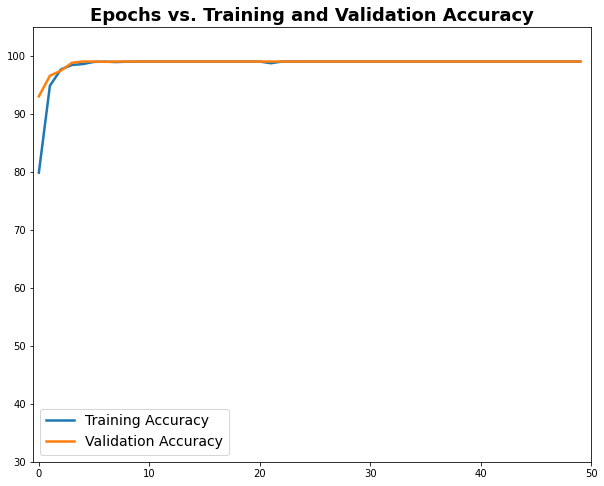

In [59]:
plot_model_acc_and_loss(history_lstm)

In [60]:
lstm_prediction = model.predict(X_test)
lstm_prediction_arg = np.argmax(lstm_prediction, axis=1)
y_test_arg=np.argmax(y_test, axis=1)

60/60 [==============================] - 1s 4ms/step


In [9]:
from sklearn.metrics import classification_report
table = classification_report(y_test_arg, lstm_prediction_arg, output_dict=False,
    target_names=['Standing', 'Eating', 'Nothing','Handswing'] )
print(table)

              precision    recall  f1-score   support

    Standing       1.00      1.00      1.00        71
      Eating       1.00      1.00      1.00        75
     Nothing       1.00      1.00      1.00        64
   Handswing       1.00      1.00      1.00        72

    accuracy                           1.00       282
   macro avg       1.00      1.00      1.00       282
weighted avg       1.00      1.00      1.00       282



1. Stacked LSTM

In [61]:

from tabnanny import verbose


stlstm_model  = Sequential()
stlstm_model.add(LSTM(units = 50, return_sequences = True, input_shape = (X.shape[1], X.shape[2])))
stlstm_model.add(Dropout(0.2))
stlstm_model.add(LSTM(units = 50, return_sequences = True))
stlstm_model.add(Dropout(0.2))
stlstm_model.add(LSTM(units = 50, return_sequences = True))
stlstm_model.add(Dropout(0.2))
stlstm_model.add(LSTM(units = 50))
stlstm_model.add(Dropout(0.2))
stlstm_model.add(Dense(units =4, activation="softmax"))
stlstm_model.compile(optimizer="adam", metrics = ['accuracy'], loss = "categorical_crossentropy")

history =stlstm_model.fit(X_train, y_train, epochs=20, verbose = 1,batch_size=64,validation_data=(X_val, y_val))


Epoch 1/20
139/139 [==============================] - 11s 36ms/step - loss: 0.3248 - accuracy: 0.8858 - val_loss: 0.0342 - val_accuracy: 0.9931
Epoch 2/20
139/139 [==============================] - 3s 20ms/step - loss: 0.0532 - accuracy: 0.9834 - val_loss: 0.0132 - val_accuracy: 0.9974
Epoch 3/20
139/139 [==============================] - 3s 19ms/step - loss: 0.0327 - accuracy: 0.9913 - val_loss: 0.0162 - val_accuracy: 0.9958
Epoch 4/20
139/139 [==============================] - 3s 20ms/step - loss: 0.0242 - accuracy: 0.9920 - val_loss: 0.0067 - val_accuracy: 0.9979
Epoch 5/20
139/139 [==============================] - 3s 20ms/step - loss: 0.0142 - accuracy: 0.9963 - val_loss: 0.0025 - val_accuracy: 0.9989
Epoch 6/20
139/139 [==============================] - 3s 21ms/step - loss: 0.0053 - accuracy: 0.9989 - val_loss: 5.3319e-04 - val_accuracy: 1.0000
Epoch 7/20
139/139 [==============================] - 3s 19ms/step - loss: 8.9676e-04 - accuracy: 0.9999 - val_loss: 3.3615e-04 - val_acc

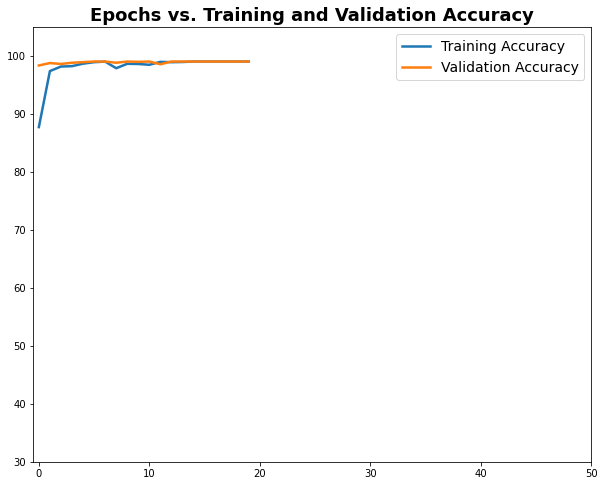

In [62]:
plot_model_acc_and_loss(history)

In [63]:
stacked_lstm_prediction = stlstm_model.predict(X_test)
print(stacked_lstm_prediction)

60/60 [==============================] - 2s 11ms/step
[[9.99962449e-01 1.23578711e-05 1.19948854e-05 1.31989427e-05]
 [9.99960423e-01 1.30164872e-05 1.25423294e-05 1.40056773e-05]
 [9.99962330e-01 1.24250855e-05 1.20385803e-05 1.32663172e-05]
 ...
 [7.17060857e-06 9.99953270e-01 2.79935957e-05 1.15551466e-05]
 [1.05922209e-05 3.47541791e-05 9.99947786e-01 6.92449657e-06]
 [1.13350261e-05 2.18809910e-05 1.12454873e-05 9.99955535e-01]]


In [64]:
stack_lstm_prediction_arg = np.argmax(stacked_lstm_prediction, axis=1)

y_test_arg=np.argmax(y_test, axis=1)

In [14]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
## Accuracy
lstm_acc = accuracy_score(y_test_arg,stack_lstm_prediction_arg)
## Precision
lstm_pre = precision_score(y_test_arg,stack_lstm_prediction_arg,average=None)
## Recall
lstm_rec = recall_score(y_test_arg,stack_lstm_prediction_arg,average=None)
## F1 Score
lstm_f1 = f1_score(y_test_arg,stack_lstm_prediction_arg,average=None)

print("accuracy = ", lstm_acc)
print("precision = ", lstm_pre)
print("recall = ", lstm_rec)
print("f1_score = ", lstm_f1)

accuracy =  1.0
precision =  [1. 1. 1. 1.]
recall =  [1. 1. 1. 1.]
f1_score =  [1. 1. 1. 1.]


In [66]:
from sklearn.metrics import classification_report
table = classification_report(y_test_arg, stack_lstm_prediction_arg, output_dict=False,
    target_names=['Standing', 'Eating', 'Watching_TV','Taking_Phone'] )
print(table)

              precision    recall  f1-score   support

    Standing       1.00      1.00      1.00       485
      Eating       1.00      1.00      1.00       484
 Watching_TV       1.00      1.00      1.00       475
Taking_Phone       1.00      1.00      1.00       452

    accuracy                           1.00      1896
   macro avg       1.00      1.00      1.00      1896
weighted avg       1.00      1.00      1.00      1896



2. Random Forest

In [73]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
#y_probas_forest = cross_val_predict(forest_clf, X_train, y_train, cv=3, method="predict_proba")
X_train_fr = X_train.reshape(-1, X_train.shape[1] * X_train.shape[2])
print(X_train_fr.shape)
y_train_arg = np.argmax(y_train, axis=1)
print(X_train_fr.shape)
forest_clf.fit(X_train_fr, y_train_arg)

(8845, 1280)
(8845, 1280)


RandomForestClassifier(random_state=42)

In [68]:
from sklearn.metrics import classification_report
X_test_fr = X_test.reshape(-1, X_test.shape[1] * X_test.shape[2])
rf_prediction_arg = forest_clf.predict(X_test_fr)
y_test_arg=np.argmax(y_test, axis=1)
table = classification_report(y_test_arg, rf_prediction_arg, output_dict=False,
    target_names=['Standing', 'Eating', 'Watching_TV','Talking_phone'] )
print(table)

               precision    recall  f1-score   support

     Standing       1.00      1.00      1.00       485
       Eating       1.00      0.99      1.00       484
  Watching_TV       1.00      1.00      1.00       475
Talking_phone       0.99      1.00      1.00       452

     accuracy                           1.00      1896
    macro avg       1.00      1.00      1.00      1896
 weighted avg       1.00      1.00      1.00      1896



In [72]:
import joblib
joblib.dump(forest_clf, "./random_forest.joblib")


['./random_forest.joblib']

3. LogisticRegression

In [70]:
from sklearn.linear_model import LogisticRegression
lr_clf = LogisticRegression(random_state=42)
#y_probas_forest = cross_val_predict(forest_clf, X_train, y_train, cv=3, method="predict_proba")
X_train_fr = X_train.reshape(-1, X_train.shape[1] * X_train.shape[2])
y_train_arg = np.argmax(y_train, axis=1)
lr_clf.fit(X_train_fr, y_train_arg)

c:\Users\Nguyen Linh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=42)

In [71]:
from sklearn.metrics import classification_report
X_test_fr = X_test.reshape(-1, X_test.shape[1] * X_test.shape[2])
lr_prediction_arg = lr_clf.predict(X_test_fr)
y_test_arg=np.argmax(y_test, axis=1)
table = classification_report(y_test_arg, lr_prediction_arg, output_dict=False,
    target_names=['Standing', 'Eating', 'Wathching_TV','Talking_phone'] )
print(table)

               precision    recall  f1-score   support

     Standing       1.00      1.00      1.00       485
       Eating       1.00      1.00      1.00       484
 Wathching_TV       1.00      1.00      1.00       475
Talking_phone       1.00      1.00      1.00       452

     accuracy                           1.00      1896
    macro avg       1.00      1.00      1.00      1896
 weighted avg       1.00      1.00      1.00      1896



4. SVC

In [21]:
from sklearn.svm import SVC
svm_clf = SVC()
X_train_fr = X_train.reshape(-1, X_train.shape[1] * X_train.shape[2])
y_train_arg = np.argmax(y_train, axis=1)
svm_clf.fit(X_train_fr, y_train_arg)

SVC()

In [22]:
from sklearn.metrics import classification_report
X_test_fr = X_test.reshape(-1, X_test.shape[1] * X_test.shape[2])
svm_prediction_arg = svm_clf.predict(X_test_fr)
y_test_arg=np.argmax(y_test, axis=1)
table = classification_report(y_test_arg, svm_prediction_arg, output_dict=False,
    target_names=['Standing', 'Eating', 'Nothing','Handswing'] )
print(table)

              precision    recall  f1-score   support

    Standing       1.00      1.00      1.00        71
      Eating       1.00      1.00      1.00        75
     Nothing       1.00      1.00      1.00        64
   Handswing       1.00      1.00      1.00        72

    accuracy                           1.00       282
   macro avg       1.00      1.00      1.00       282
weighted avg       1.00      1.00      1.00       282



In [23]:
y_test_arg

array([1, 3, 0, 3, 0, 1, 1, 1, 1, 3, 2, 2, 1, 3, 1, 1, 0, 2, 1, 0, 0, 0,
       2, 0, 0, 3, 2, 3, 2, 2, 1, 0, 0, 3, 3, 0, 3, 2, 3, 3, 0, 0, 1, 0,
       0, 0, 2, 1, 1, 2, 1, 0, 1, 3, 2, 2, 2, 0, 1, 0, 3, 2, 3, 2, 2, 1,
       1, 2, 3, 2, 2, 2, 3, 2, 3, 1, 1, 1, 2, 0, 1, 0, 1, 0, 3, 1, 1, 1,
       0, 1, 2, 3, 3, 1, 2, 2, 3, 0, 0, 2, 3, 2, 3, 3, 1, 2, 2, 1, 1, 0,
       3, 3, 1, 0, 2, 2, 0, 0, 0, 1, 2, 0, 0, 0, 0, 2, 1, 0, 1, 2, 1, 2,
       3, 0, 1, 1, 2, 2, 1, 1, 1, 3, 0, 3, 3, 1, 0, 0, 3, 0, 0, 2, 2, 3,
       3, 1, 2, 0, 0, 3, 1, 3, 0, 2, 1, 3, 1, 3, 2, 3, 0, 1, 1, 0, 1, 0,
       3, 2, 3, 3, 3, 3, 3, 3, 0, 0, 2, 0, 3, 2, 1, 2, 2, 1, 3, 3, 3, 0,
       2, 1, 3, 3, 1, 3, 3, 0, 0, 1, 2, 0, 2, 1, 2, 0, 3, 3, 0, 3, 0, 1,
       1, 2, 3, 2, 3, 1, 0, 2, 3, 1, 1, 1, 2, 0, 3, 0, 2, 3, 1, 0, 3, 0,
       1, 1, 3, 1, 3, 0, 1, 2, 1, 3, 1, 2, 1, 1, 3, 0, 1, 2, 3, 1, 2, 0,
       3, 0, 3, 0, 3, 0, 3, 2, 2, 0, 2, 1, 1, 1, 0, 3, 2, 0], dtype=int64)